Previously on solving PDEs:

Solve 2-D Laplace equation on a Cartesian boundary with Dirichlet boundary condition:

solve

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0
$$

for $(x, y) \in [0, 1] \times [0, 1]$

s.t.

$$
u|_{x=0} = f_0(y) \\
u|_{x=1} = f_1(y) \\
u|_{y=0} = g_0(x) \\
u|_{y=1} = g_1(x)
$$

The following re-parameterization is used so that the boundary conditions are satisfied:

$$
\tilde{u}(x,y) = A(x,y) + x(1−x)y(1−y)NN(x,y) \\
A(x, y) = (1−x)f_0(y)+xf_1(y)+(1−y)\{g_0(x)−[(1−x)g_0(0)+xg_0(1)]\}+y\{g_1(x)−[(1−x)g_1(0)+xg_1(1)]\}
$$

Here we solve for

$$
u|_{x=0} = \sin(\pi y) \\
u|_{x=1} = 0 \\
u|_{y=0} = 0 \\
u|_{y=1} = 0
$$.

In [1]:
# the pde module is packaged now but is very limited in the problems they can solve
from neurodiffeq import diff
from neurodiffeq.pde import DirichletBVP2D, ExampleGenerator2D, Monitor2D, solve2D, make_animation
from neurodiffeq.networks import FCNN

import numpy as np
import torch
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d  import Axes3D

<IPython.core.display.Javascript object>


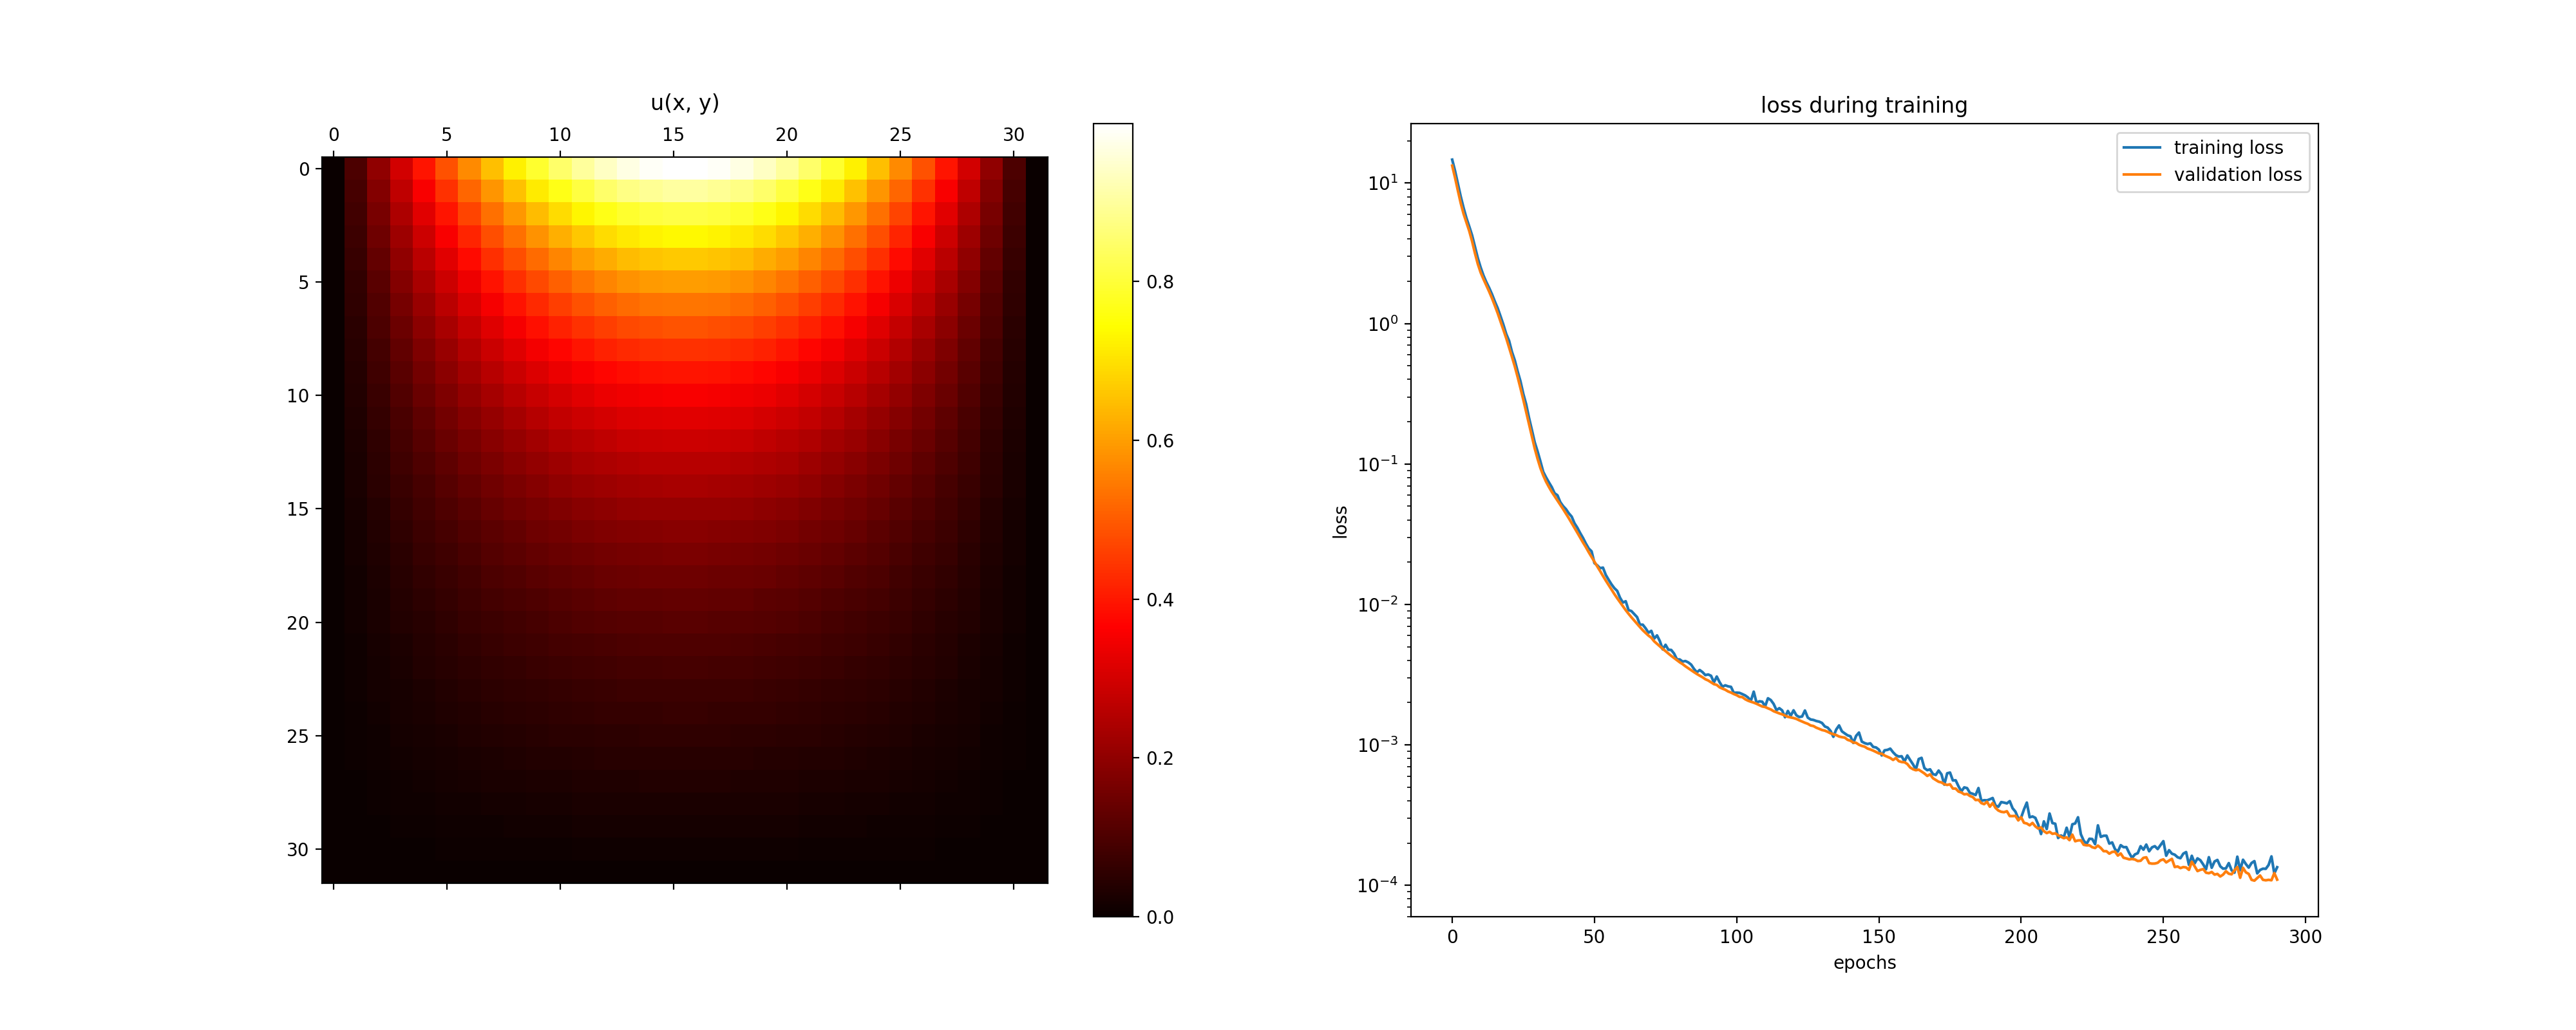

In [2]:
%matplotlib notebook
laplace = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2)
BC = DirichletBVP2D(
    x_min=0, x_min_val=lambda y: torch.sin(np.pi*y), 
    x_max=1, x_max_val=lambda y: 0, 
    y_min=0, y_min_val=lambda x: 0, 
    y_max=1, y_max_val=lambda x: 0
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)

solution_neural_net_laplace, _ = solve2D(
    pde=laplace, condition=BC, xy_min=[0, 0], xy_max=[1, 1],
    net=net, max_epochs=300, 
    train_generator=ExampleGenerator2D([32, 32], [0, 0], [1, 1], method='equally-spaced-noisy'),
    batch_size=64,
    monitor=Monitor2D(check_every=10, xy_min=[0, 0], xy_max=[1, 1])
)

In [3]:
# a helper function to plot surface
def plt_surf(xx, yy, zz, z_label='u', x_label='x', y_label='y', title=''):
    fig  = plt.figure(figsize=(16, 8))
    ax   = Axes3D(fig)
    surf = ax.plot_surface(xx, yy, zz, rstride=2, cstride=1, alpha=0.8, cmap='hot')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    ax.set_proj_type('ortho')
    plt.show()

<IPython.core.display.Javascript object>


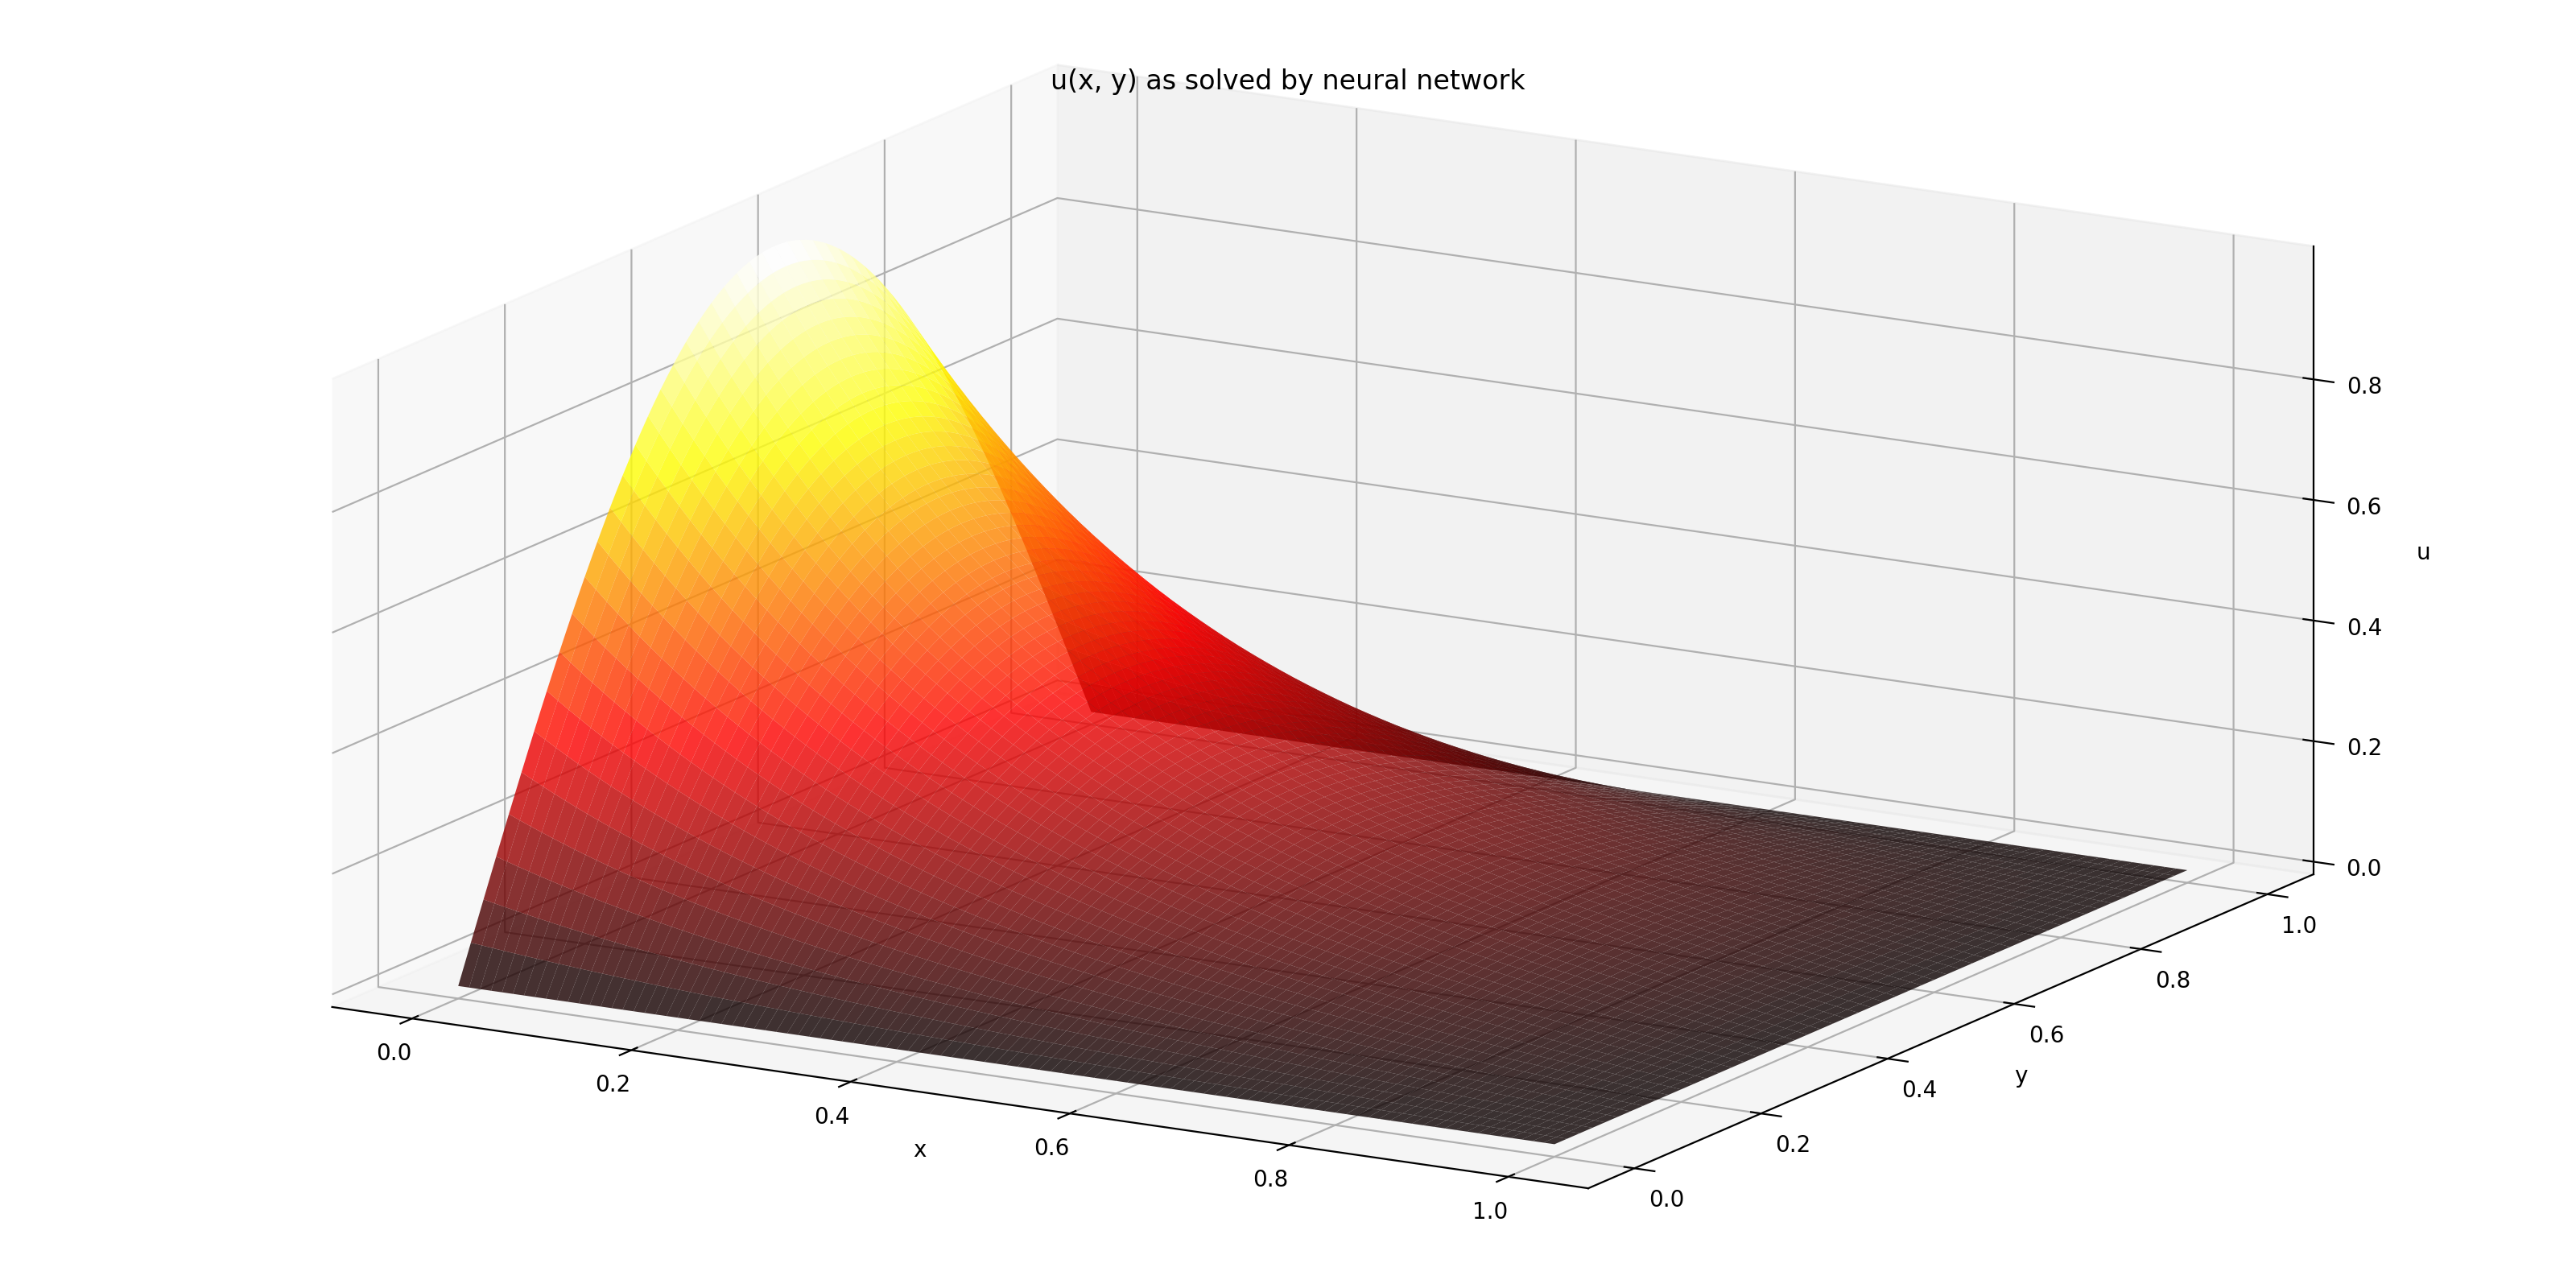

In [4]:
xs, ys = np.linspace(0, 1, 101), np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
sol_net = solution_neural_net_laplace(xx, yy, as_type='np')
plt_surf(xx, yy, sol_net, title='u(x, y) as solved by neural network')

In this case, the analytical solution is

$$
u(x, y) = \frac{\sin(\pi y) \sinh(\pi(1-x))}{\sinh(\pi)}
$$

The residual of the neural network solution is as below:

<IPython.core.display.Javascript object>


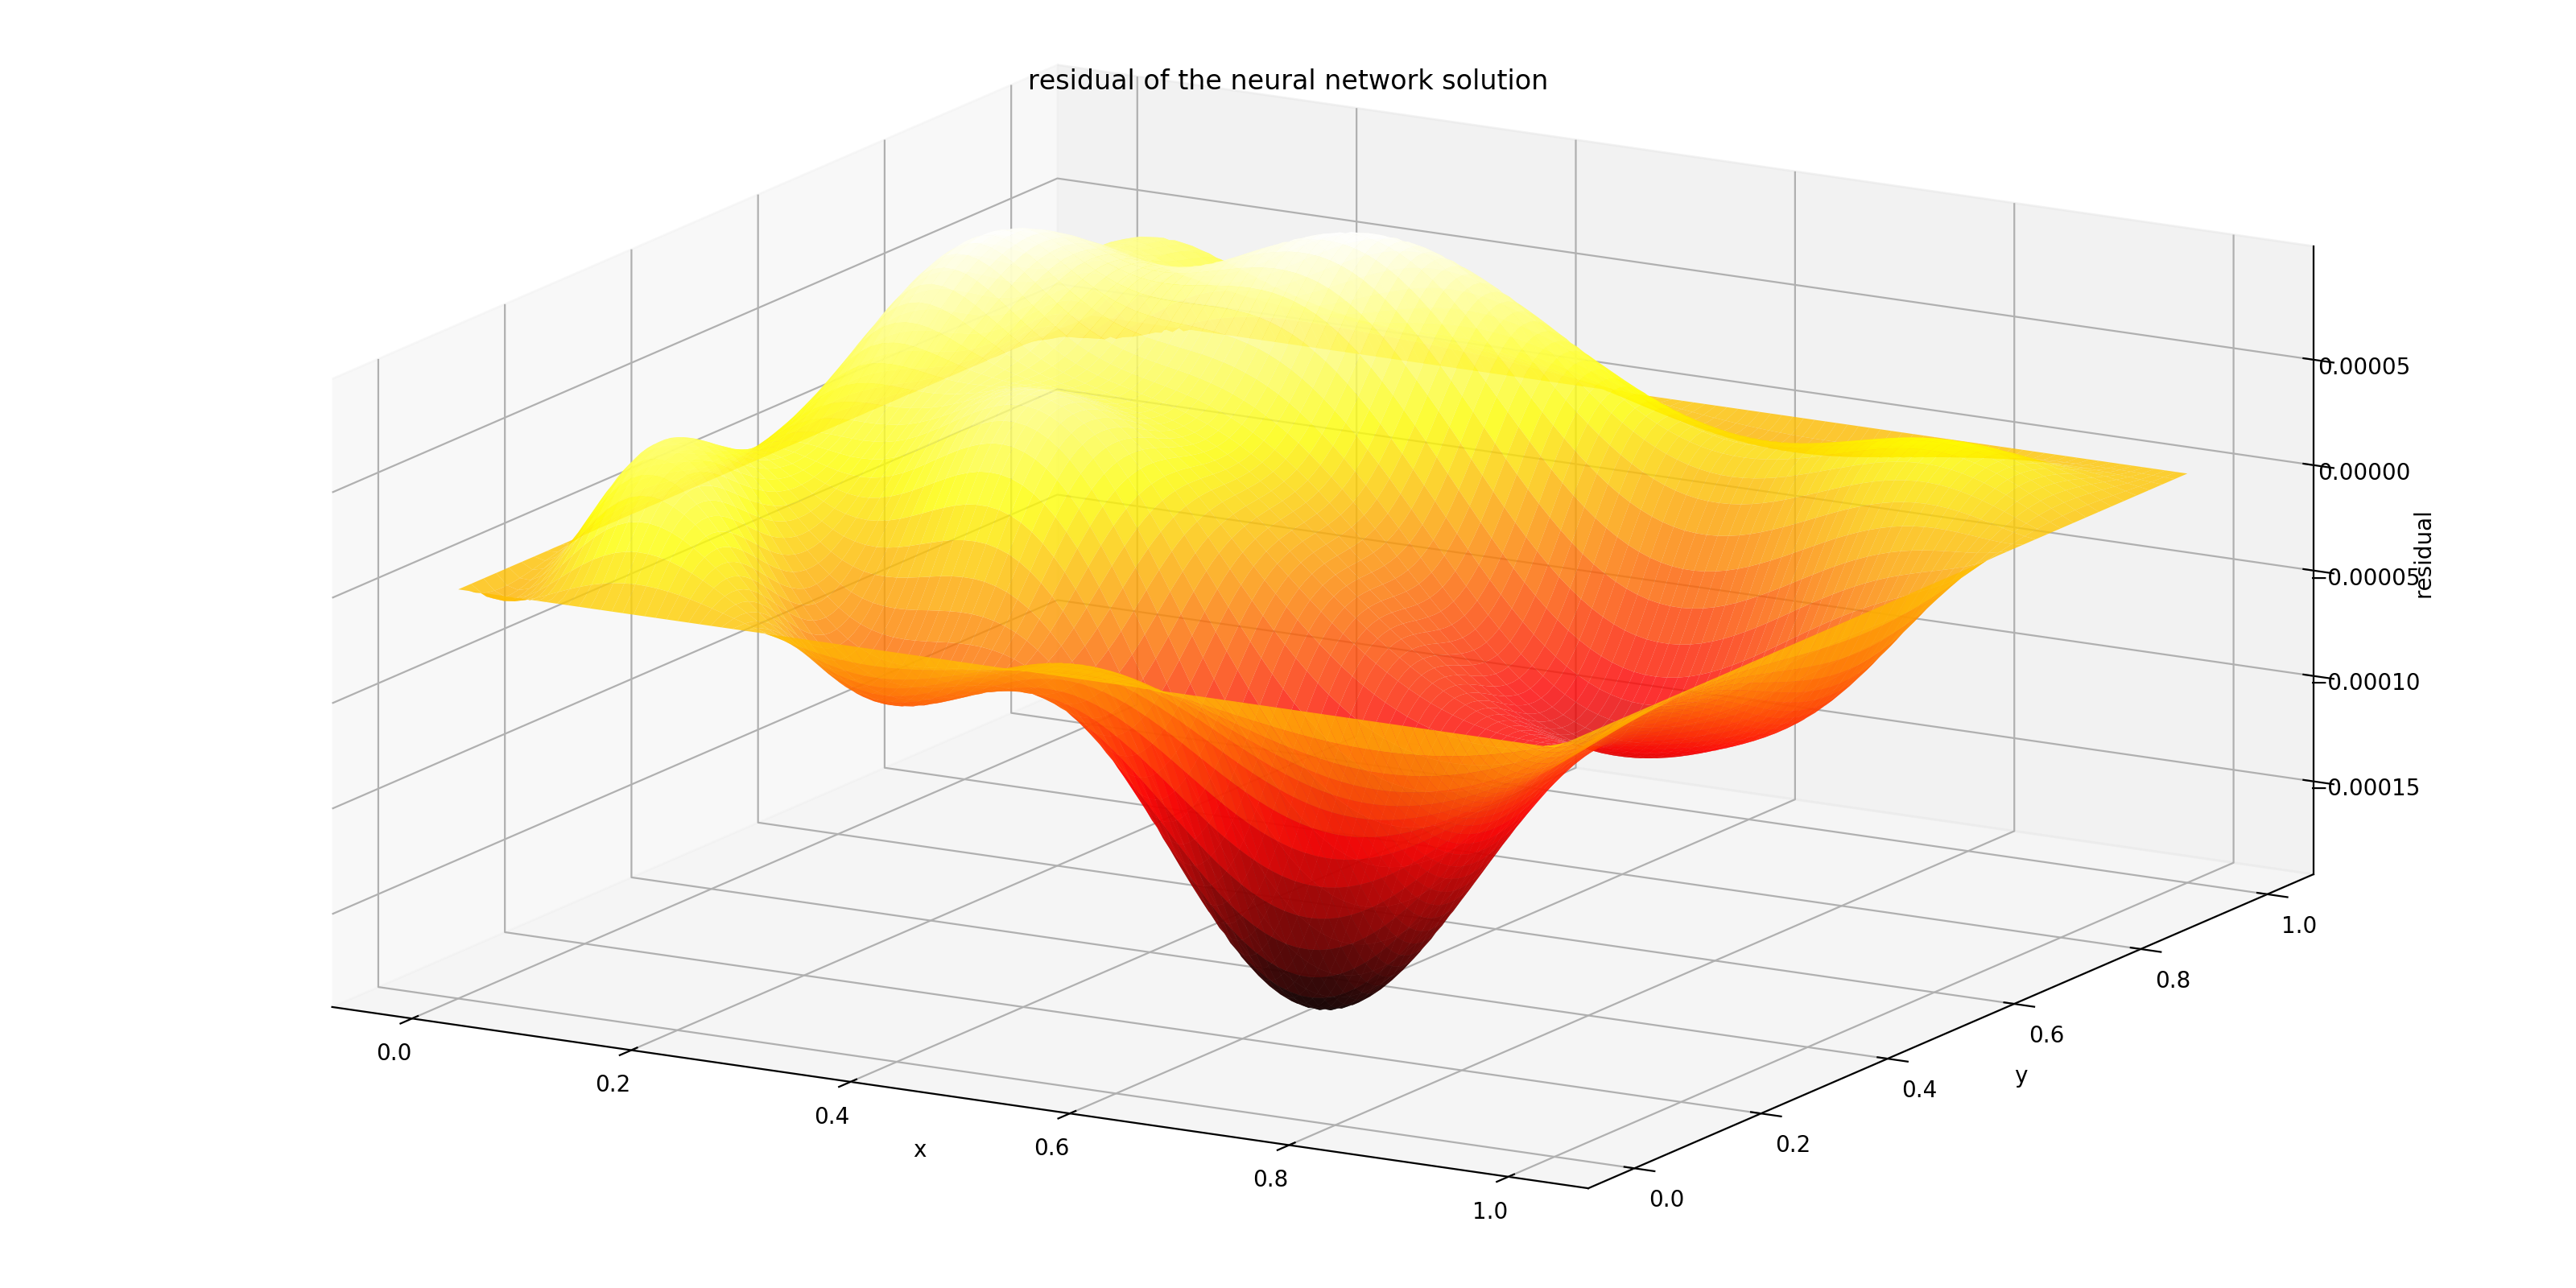

In [5]:
solution_analytical_laplace = lambda x, y: np.sin(np.pi*y) * np.sinh(np.pi*(1-x))/np.sinh(np.pi)
sol_ana = solution_analytical_laplace(xx, yy)
plt_surf(xx, yy, sol_net-sol_ana, z_label='residual', title='residual of the neural network solution')

This week on solving PDEs:

Solve 1-D heat equation:

solve

$$
\frac{\partial u}{\partial t} - k \frac{\partial^2 u}{\partial x^2} = 0
$$

for $(x, t) \in [0, L] \times [0, T]$

s.t.

$$
u|_{x=0} = f_0(t) \\
u|_{x=L} = f_L(t) \\
u|_{t=0} = g_0(x) \\
$$

For the neural network solution, the following re-parameterization is used so that the boundary conditions are satisfied. It's like the previous one, but simpler, because we need only satisfy 3 'boundary condition':

$$
\tilde{u}(x,t) = A(x,t) + x(1−x)tNN(x,t) \\
A(x, y) = (1−x)f_0(t)+xf_L(t)+(1−t)\{g_0(x)−[(1−x)g_0(0)+xg_0(1)]\}
$$

Here we solve for
$$
u|_{x=0} = 0 \\
u|_{x=L} = 0 \\
u|_{t=0} = \sin(\pi \frac{x}{L})
$$.

In [6]:
class IBVP:
    
    def __init__(self, x_min, x_min_val, x_max, x_max_val, t_min, t_min_val, t_max):
        self.x_min, self.x_min_val = x_min, x_min_val
        self.x_max, self.x_max_val = x_max, x_max_val
        self.t_min, self.t_min_val = t_min, t_min_val
        self.t_max = t_max

    def enforce(self, u, x, t):
        x_tilde = (x-self.x_min) / (self.x_max-self.x_min)
        t_tilde = (t-self.t_min) / (self.t_max-self.t_min)
        Axt = (1-x_tilde)*self.x_min_val(t) + x_tilde*self.x_max_val(t) + \
              (1-t_tilde)*( self.t_min_val(x) - (1-x_tilde)*self.t_min_val(self.x_min * torch.ones_like(x_tilde))
                                              -    x_tilde *self.t_min_val(self.x_max * torch.ones_like(x_tilde))
                          ) 
        return Axt + x_tilde*(1-x_tilde)*t_tilde*u

<IPython.core.display.Javascript object>


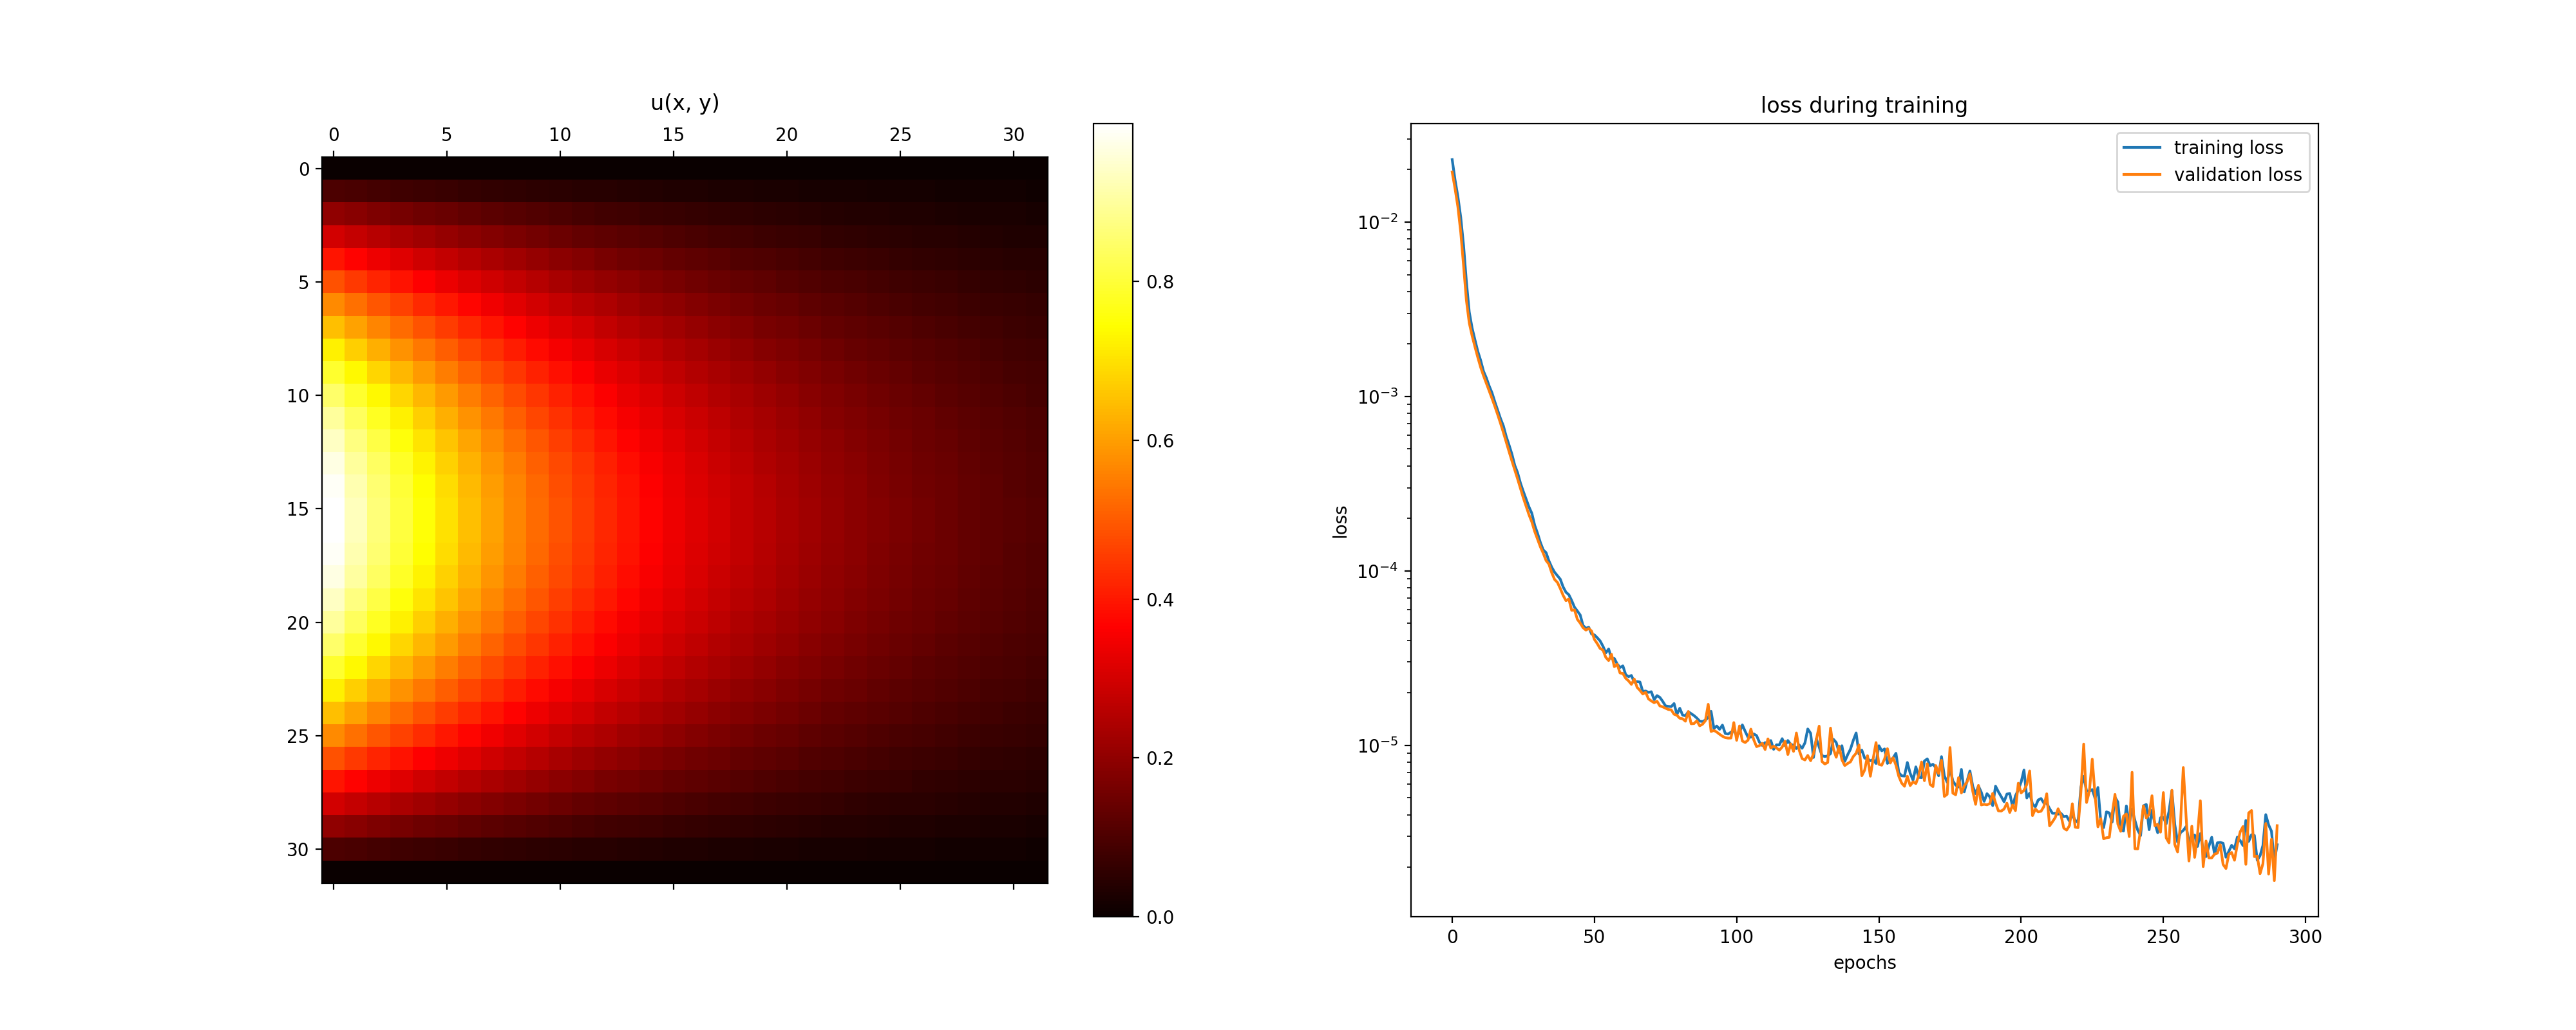

In [7]:
%matplotlib notebook

k, L, T = 0.3, 2, 3
heat = lambda u, x, t: diff(u, t) - k * diff(u, x, order=2)


BC = IBVP(
    x_min=0, x_min_val=lambda t: 0, 
    x_max=L, x_max_val=lambda t: 0,
    t_min=0, t_min_val=lambda x: torch.sin(np.pi * x / L), 
    t_max=T
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)

solution_neural_net_heat, _ = solve2D(
    pde=heat, condition=BC, xy_min=[0, 0], xy_max=[L, T],
    net=net, max_epochs=300, 
    train_generator=ExampleGenerator2D([32, 32], [0, 0], [L, T], method='equally-spaced-noisy'),
    batch_size=64,
    monitor=Monitor2D(check_every=10, xy_min=[0, 0], xy_max=[L, T])
)

<IPython.core.display.Javascript object>


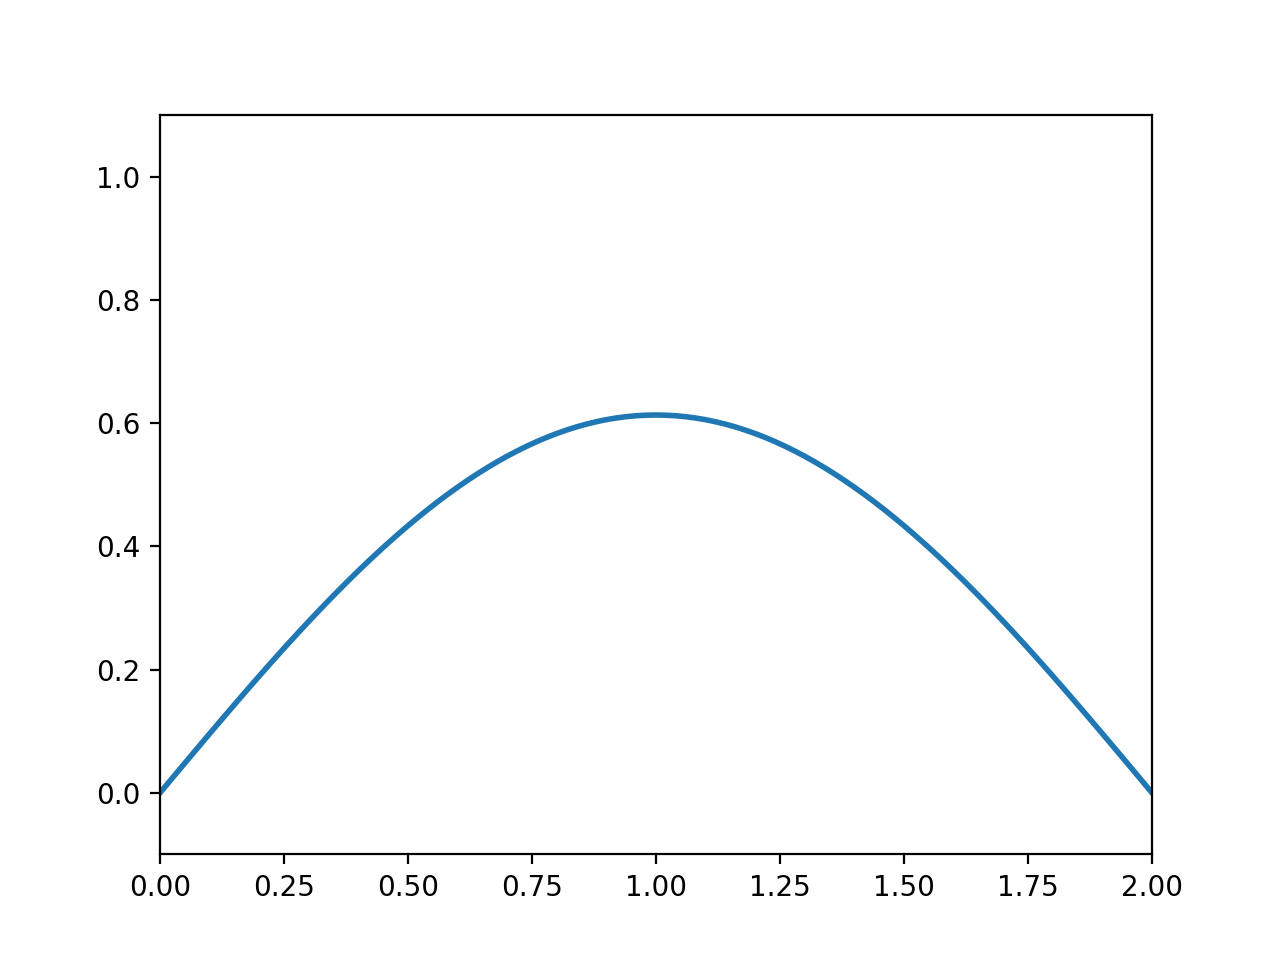

In [8]:
xs = np.linspace(0, L, 101)
ts = np.linspace(0, T, 101) 
xx, tt = np.meshgrid(xs, ts)
make_animation(solution_neural_net_heat, xs, ts)

In this case, the analytical solution is

$$
u(x, t) = \sin(\pi \frac{x}{L}) \exp(\frac{-k \pi^2 t}{L^2})
$$

The residual of the neural network solution is as below:

<IPython.core.display.Javascript object>


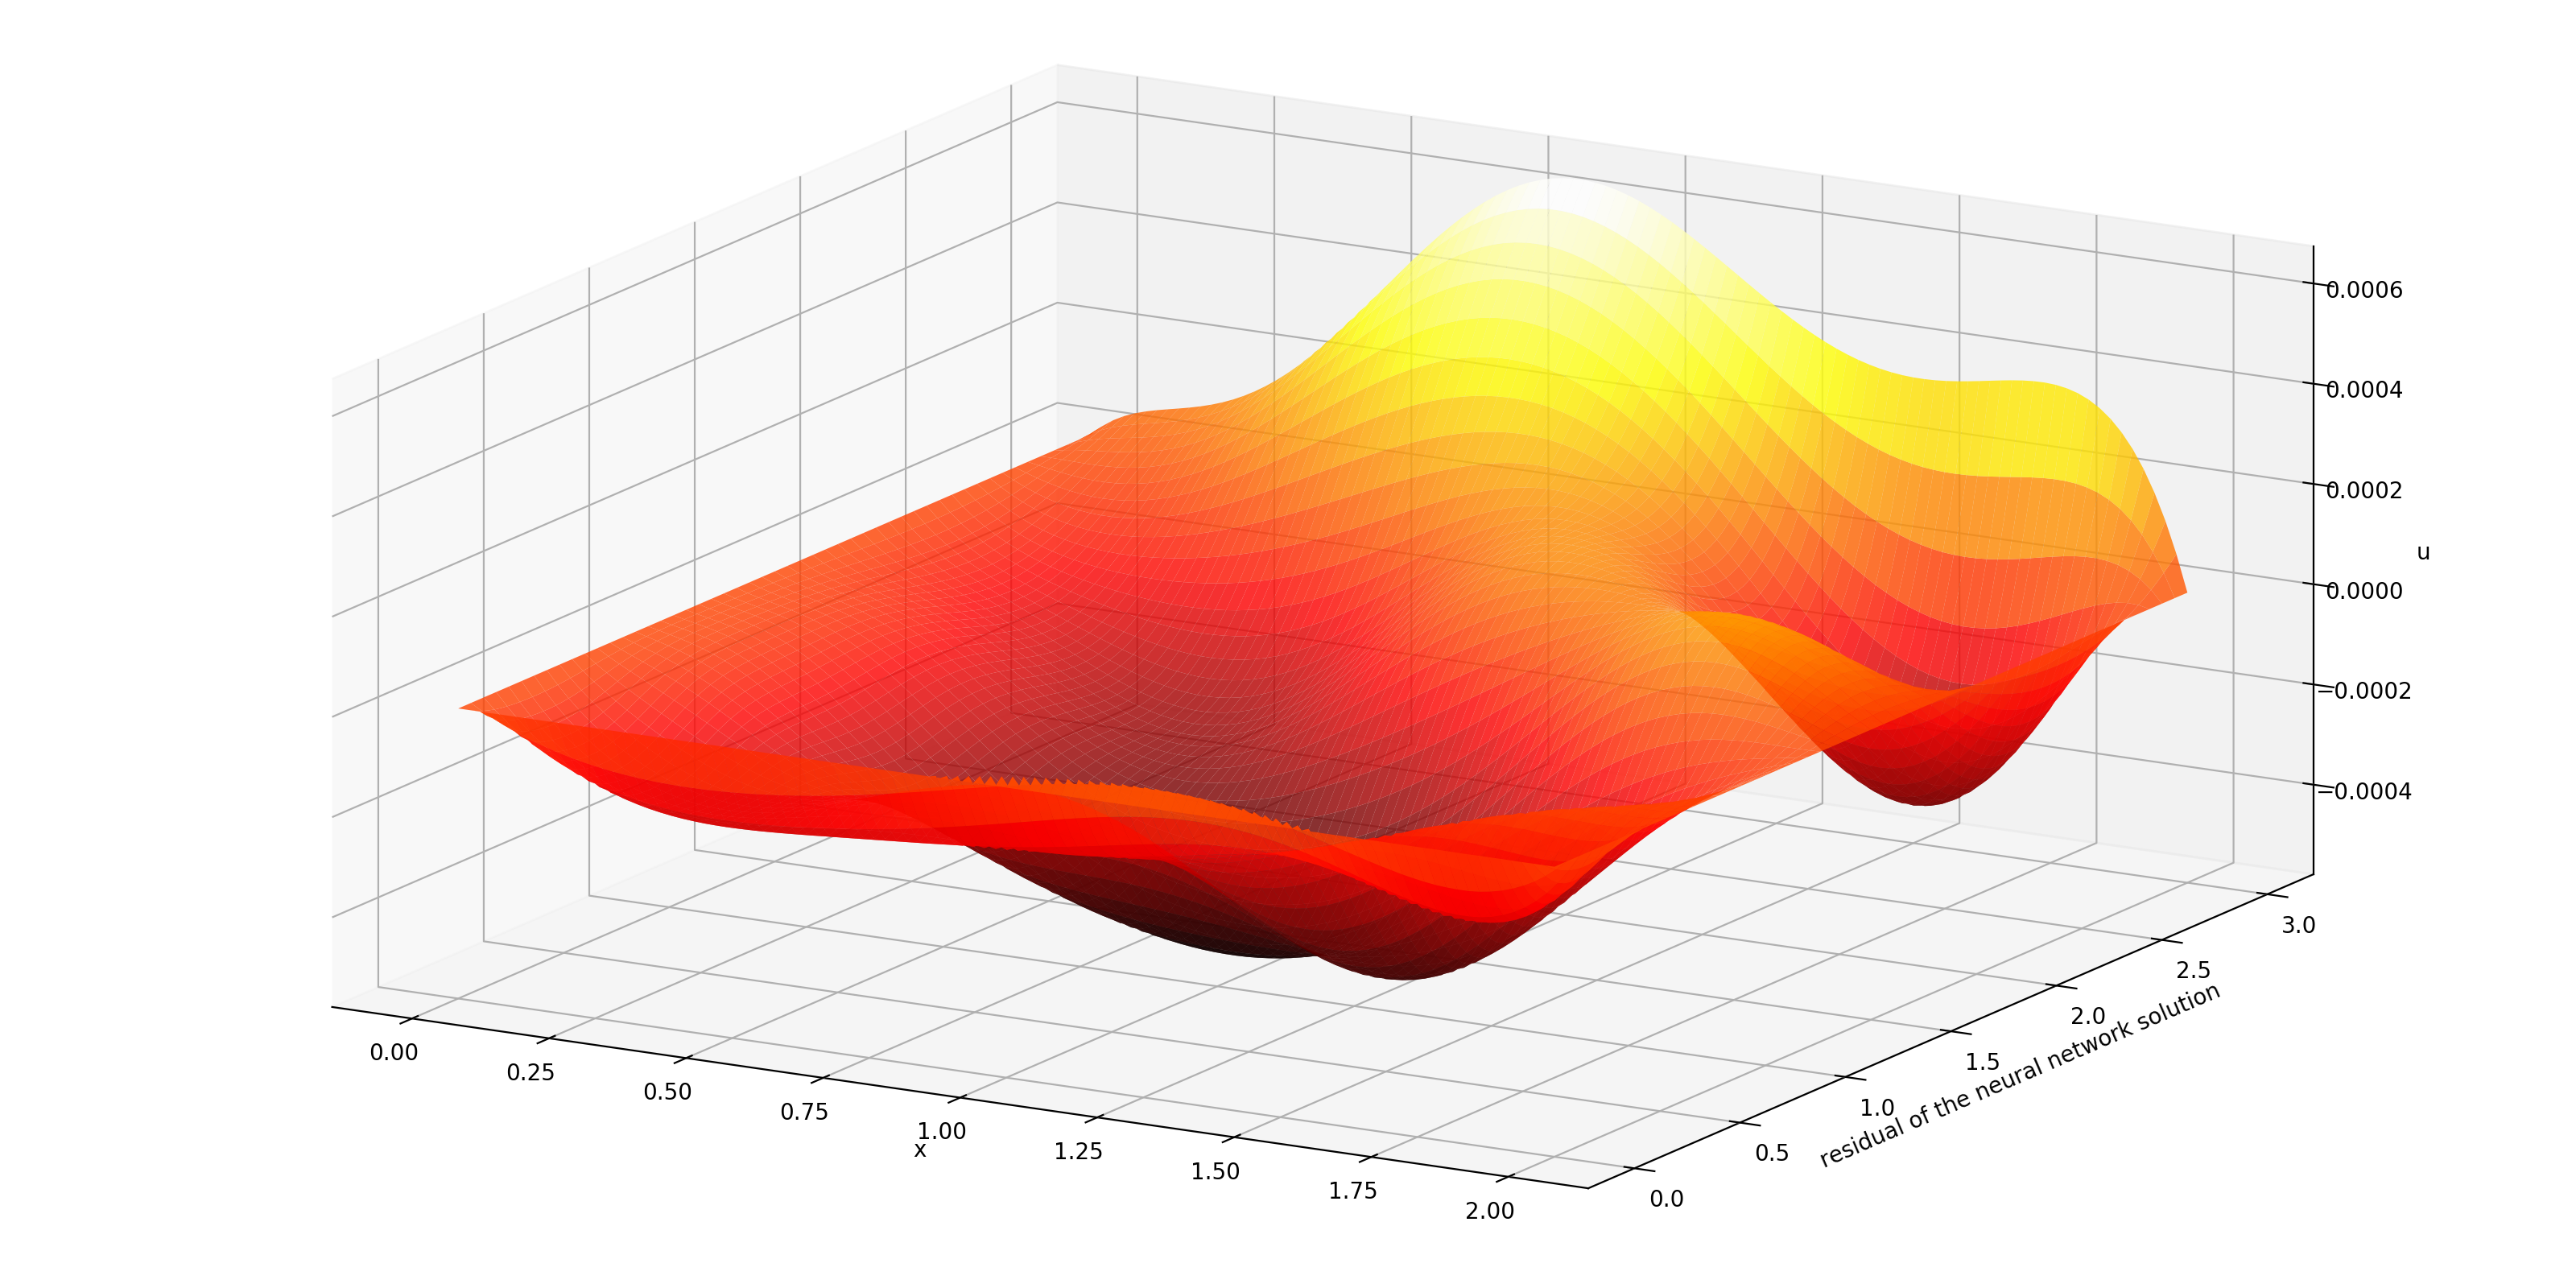

In [9]:
solution_analytical_heat = lambda x, t: np.sin(np.pi*x/L) * np.exp(-k * np.pi**2 * t / L**2)
sol_ana = solution_analytical_heat(xx, tt)
sol_net = solution_neural_net_heat(xx, tt, as_type='np')
plt_surf(xx, tt, sol_net-sol_ana, y_label='residual of the neural network solution')

Solve 1-D Burgers' equation:

solve

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0
$$

for $(x, t) \in [0, L] \times [0, T]$

s.t.

$$
u|_{x=0} = f_0(t) \\
u|_{x=L} = f_L(t) \\
u|_{t=0} = g_0(x) \\
$$

We can use the same reparameterization we used for solving the heat equation.

Here we solve for a special case whose analytical solution is known
$$
u|_{x=0} = 0 \\
u|_{x=1} = 0 \\
u|_{t=0} = \frac{2\nu\pi\sin(\pi x)}{a + \cos(\pi x)}
$$

the analytical solution is
$$
u(x, t) = \frac{2\nu\pi\exp(-\pi^2 \nu t)\sin(\pi x)}{a + \exp(-\pi^2 \nu t)cos(\pi x)}
$$

<IPython.core.display.Javascript object>


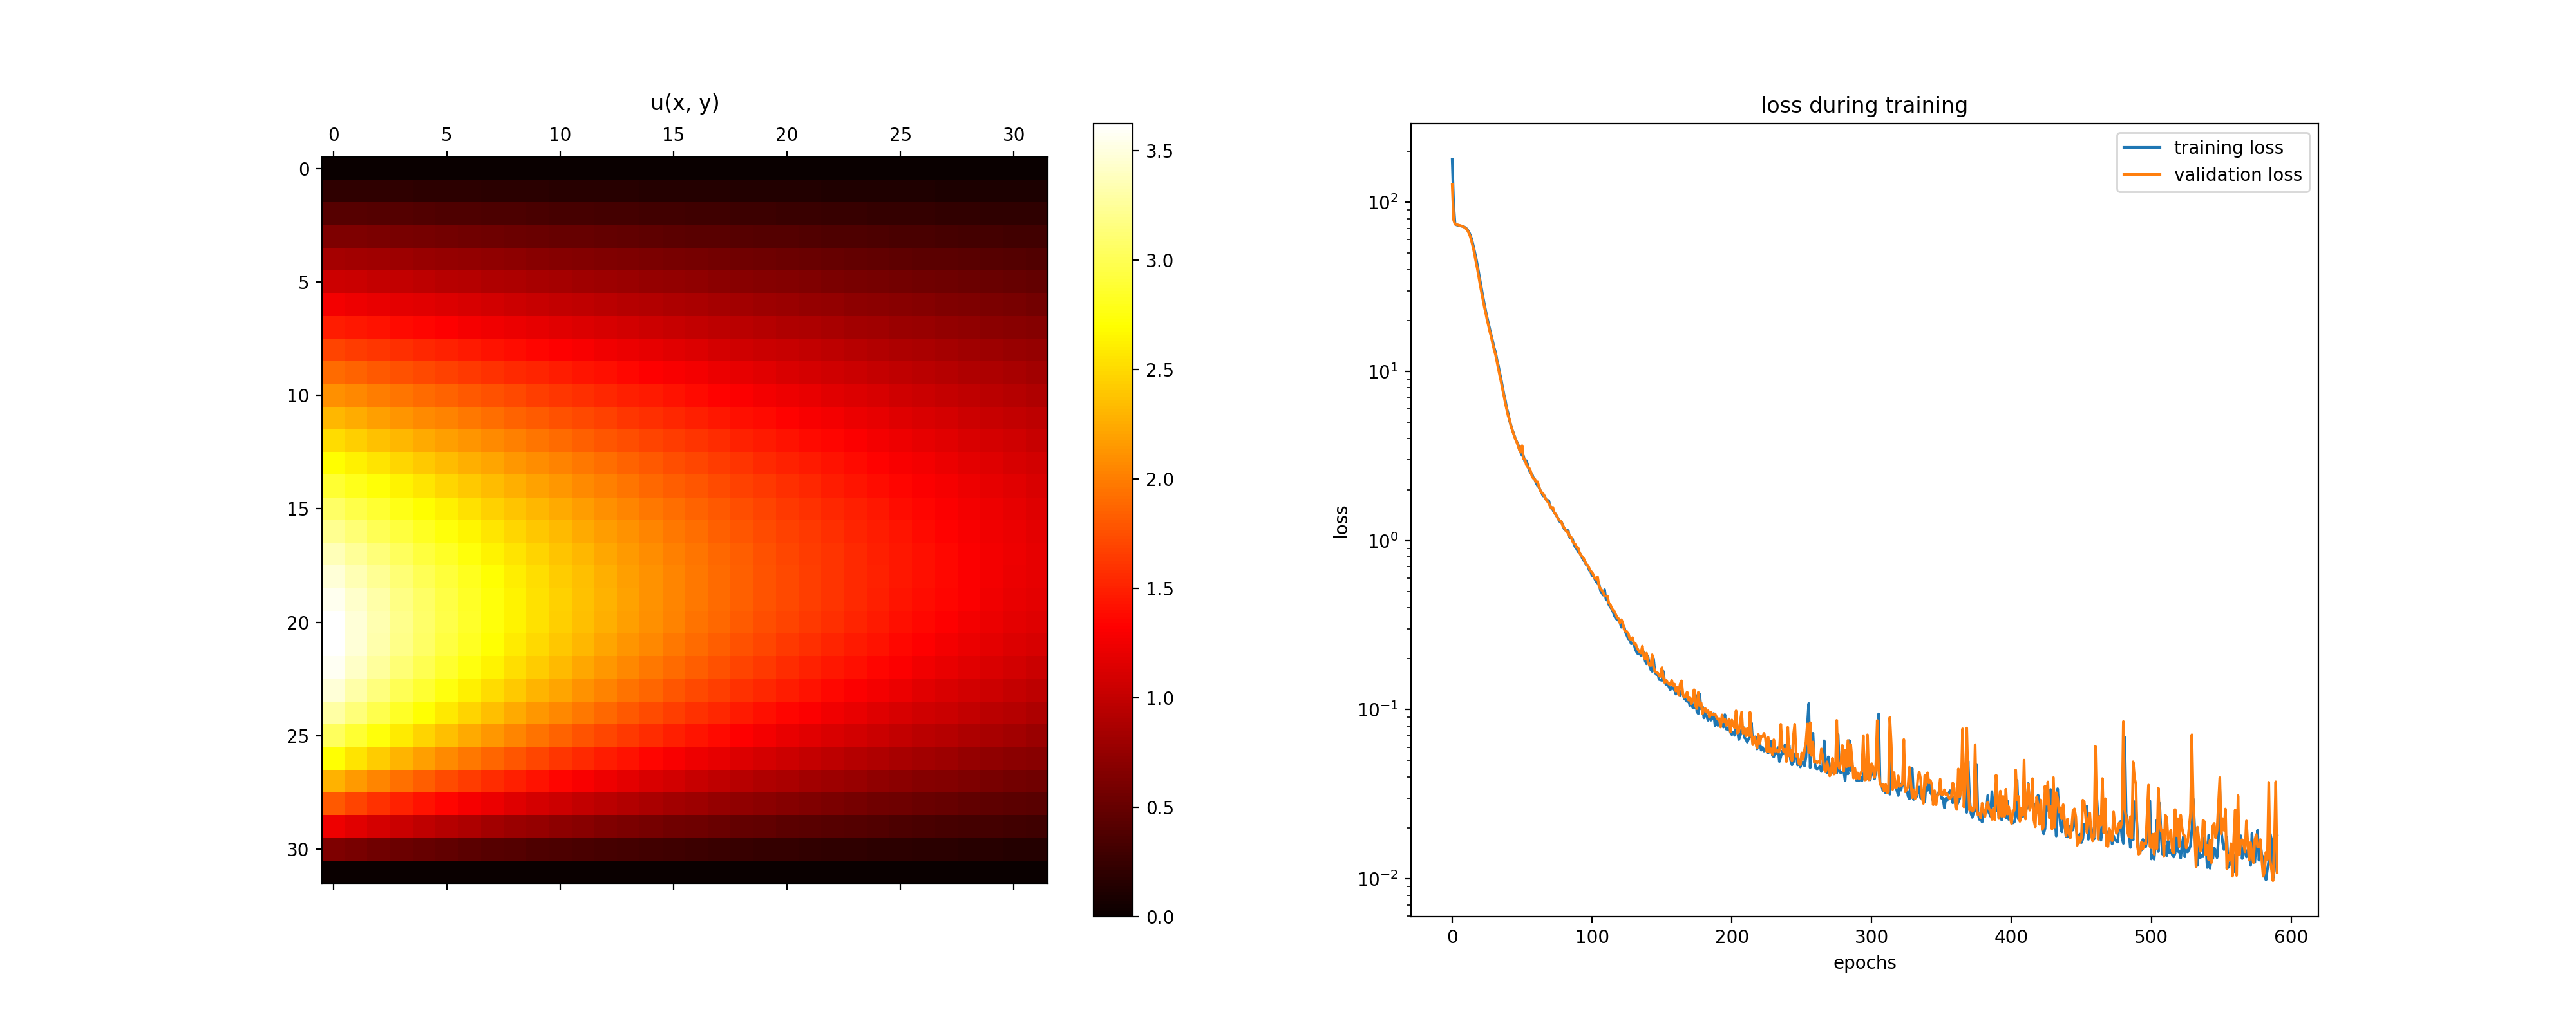

In [31]:
%matplotlib notebook

nu = 1
a = 2 # a parameter for the special case
T = 0.1

burgers = lambda u, x, t: diff(u, t) + u * diff(u, x) - nu * diff(u, x, order=2)

ibvp = IBVP(
    x_min=0, x_min_val=lambda t: 0, 
    x_max=1, x_max_val=lambda t: 0,
    t_min=0, t_min_val=lambda x: 2*v*np.pi*torch.sin(np.pi*x) / (a + torch.cos(np.pi*x)), 
    t_max=T
)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)

solution_neural_net_burgers, _ = solve2D(
    pde=burgers, condition=ibvp, xy_min=[0, 0], xy_max=[1, T],
    net=net, max_epochs=600, 
    train_generator=ExampleGenerator2D([50, 50], [0, 0], [1, T], method='equally-spaced-noisy'),
    batch_size=64,
    monitor=Monitor2D(check_every=10, xy_min=[0, 0], xy_max=[1, T])
)

<IPython.core.display.Javascript object>


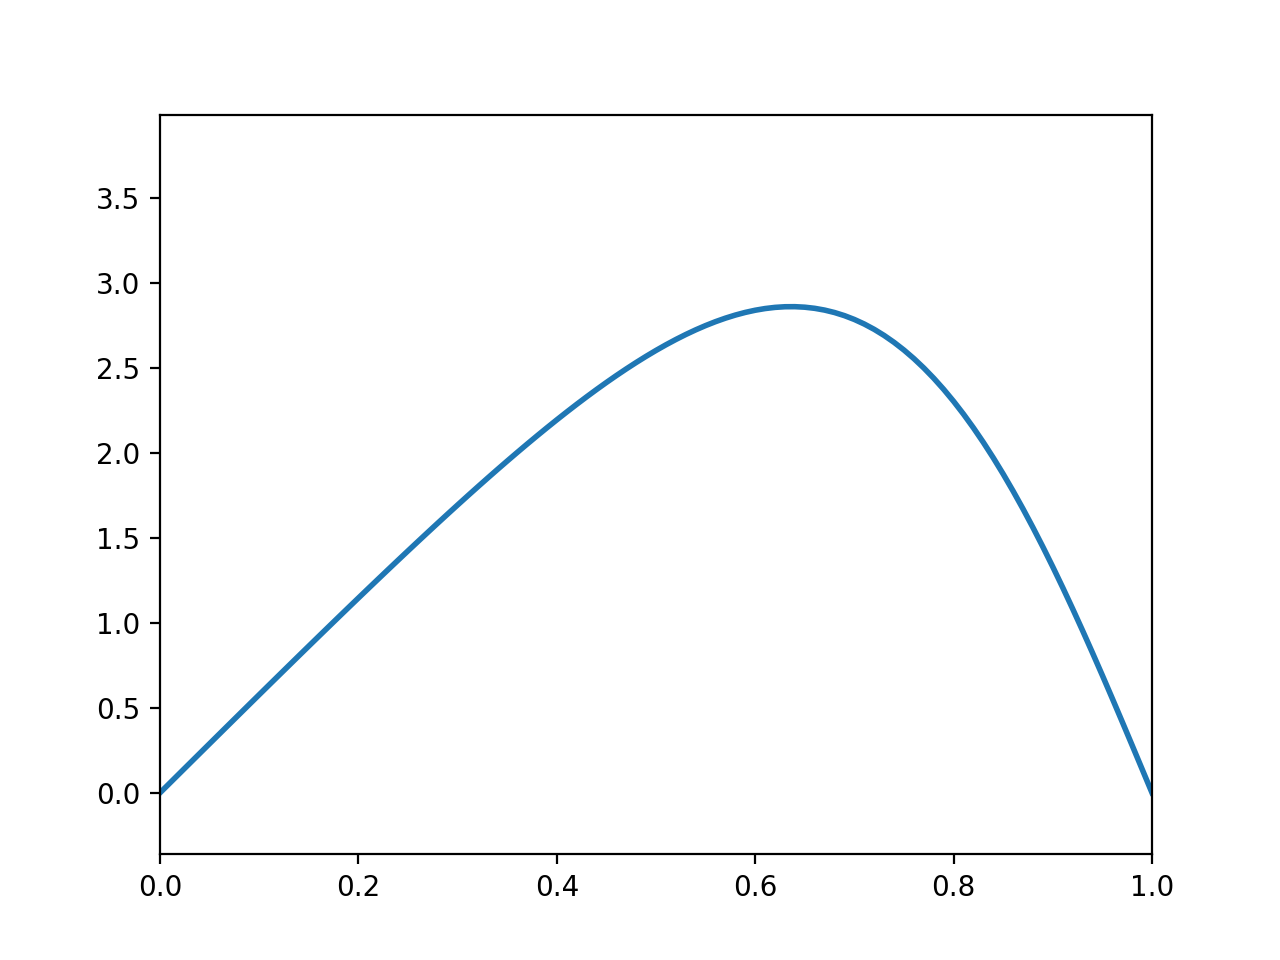

In [32]:
xs = np.linspace(0, 1, 101)
ts = np.linspace(0, T, 101) 
xx, tt = np.meshgrid(xs, ts)
make_animation(solution_neural_net_burgers, xs, ts)

The residual of the neural network solution is as below:

<IPython.core.display.Javascript object>


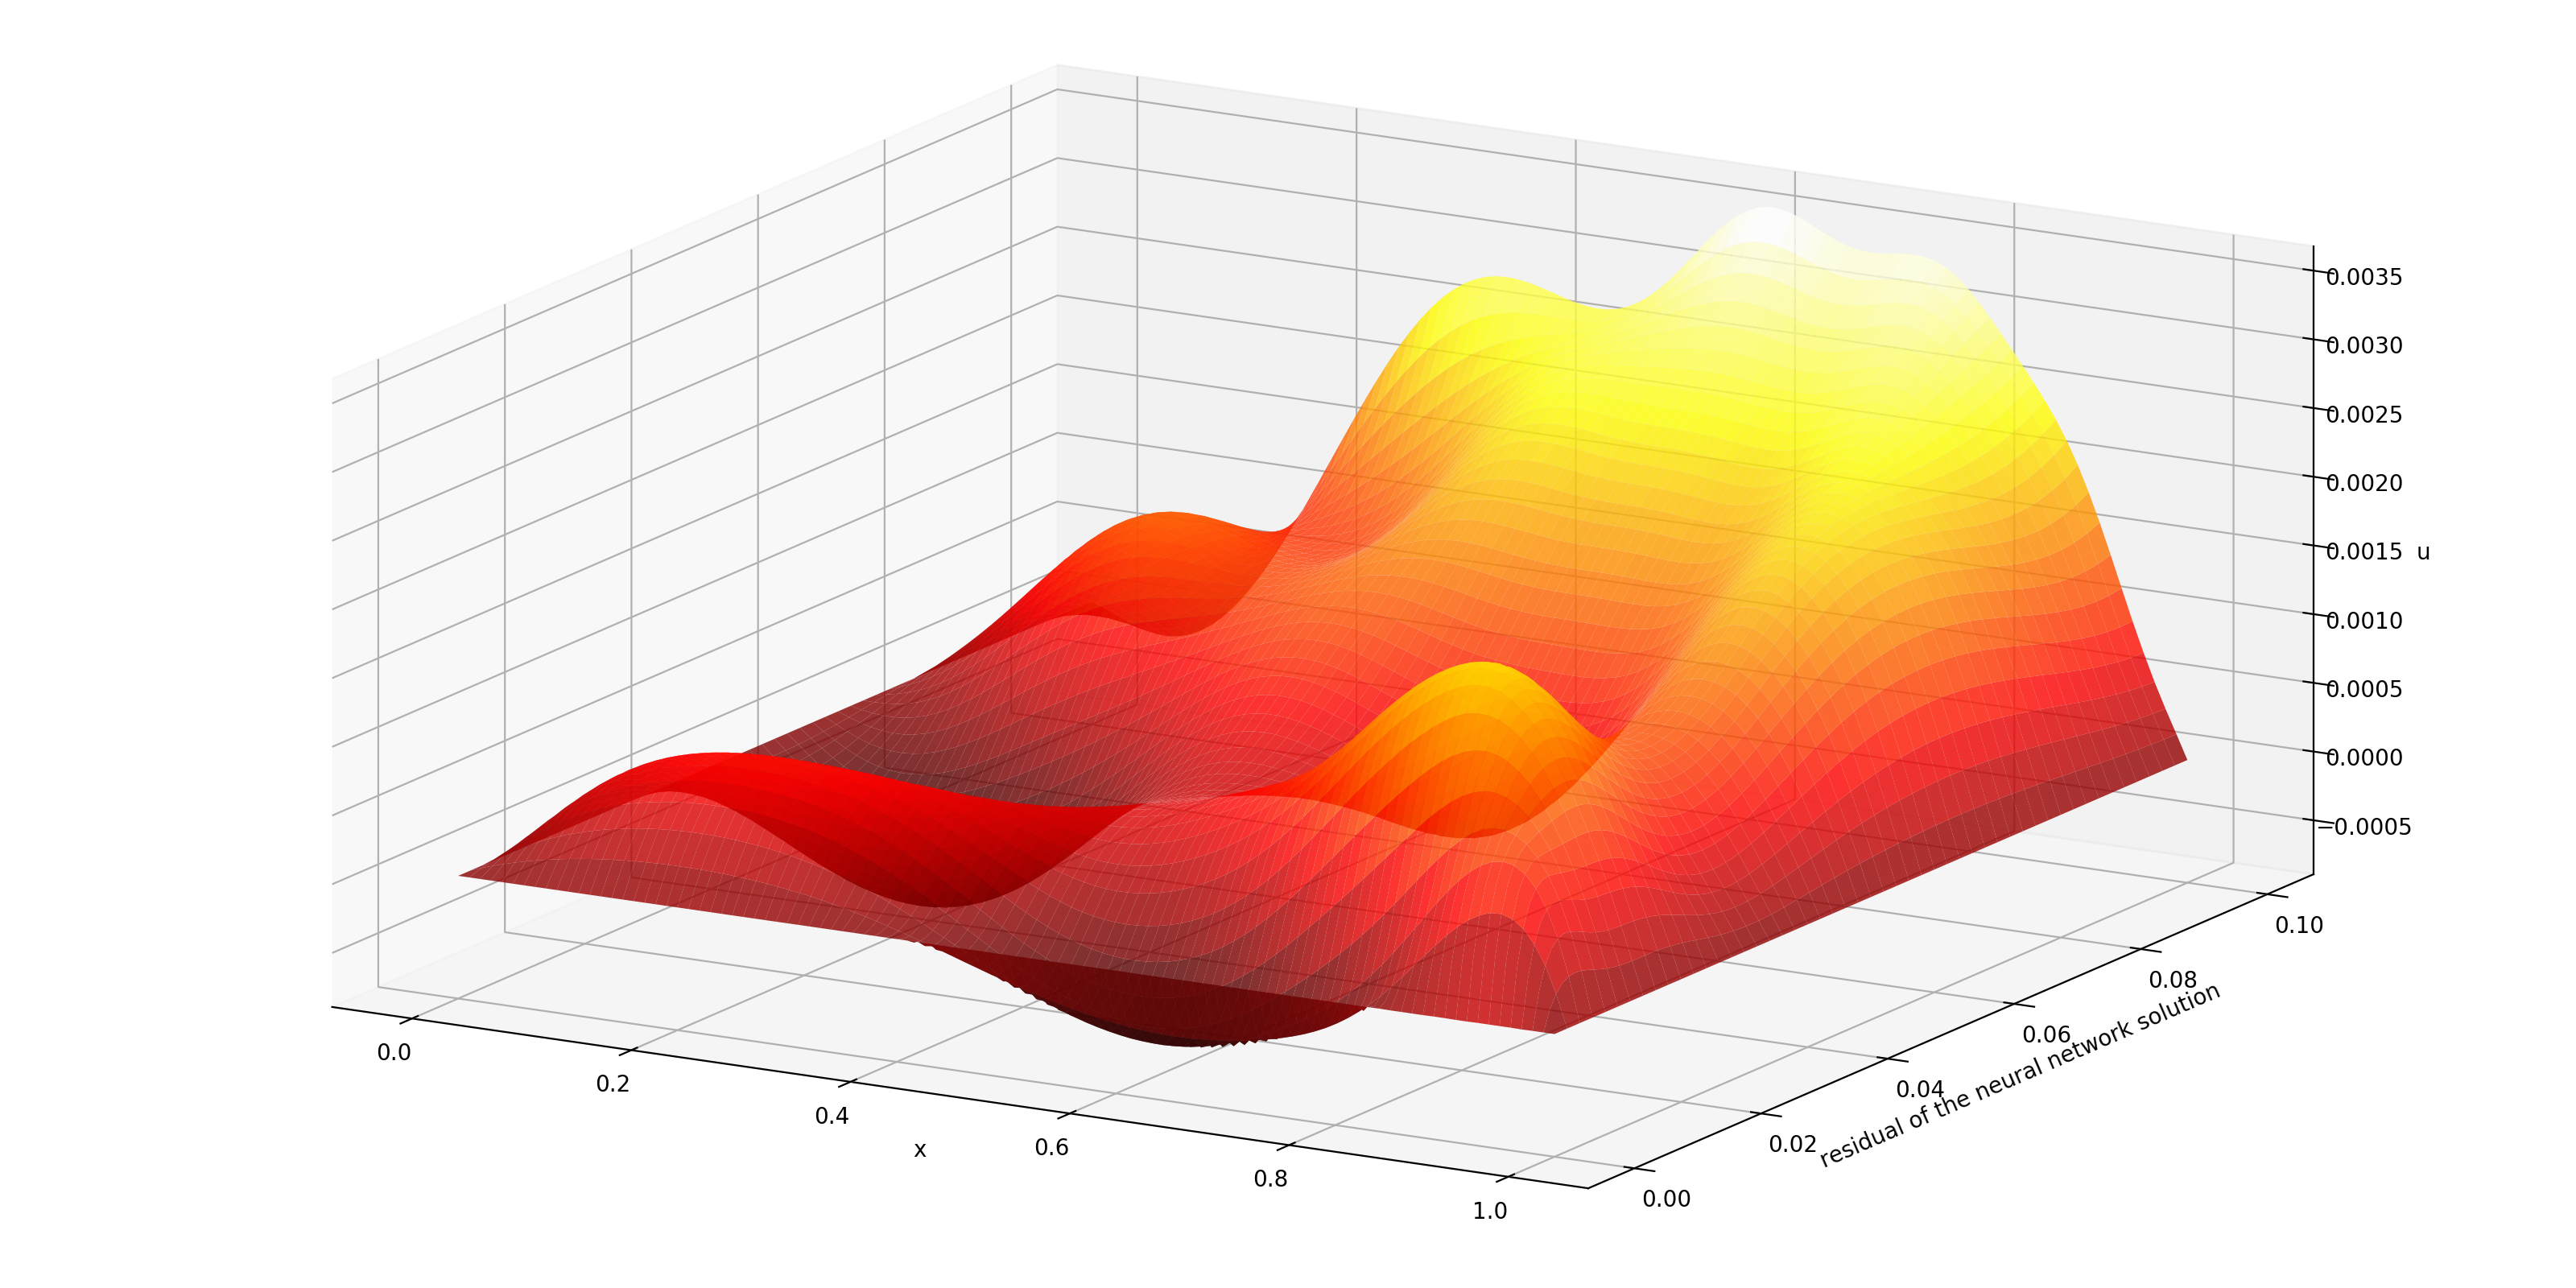

In [33]:
def solution_analytical_burgers(x, t):
    numer = 2*nu*np.pi * np.exp(-np.pi**2*nu*t) * np.sin(np.pi*x)
    denom = a + np.exp(-np.pi**2*nu*t) * np.cos(np.pi*x)
    return numer / denom
sol_ana = solution_analytical_burgers(xx, tt)
sol_net = solution_neural_net_burgers(xx, tt, as_type='np')
plt_surf(xx, tt, sol_net-sol_ana, y_label='residual of the neural network solution')